In [24]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import random
from torch.utils.data import Subset

In [25]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])  

In [26]:
train_dataset = datasets.ImageFolder(root='train_70001', transform=transform)
val_dataset = datasets.ImageFolder(root='Validation_19000', transform=transform)
test_dataset = datasets.ImageFolder(root='test_5413', transform=transform)

In [27]:
def get_subset(dataset, num_images):
    if num_images > len(dataset):
        raise ValueError(f"Requested {num_images} images, but dataset only has {len(dataset)} images.")
    indices = random.sample(range(len(dataset)), num_images)
    return Subset(dataset, indices)

In [28]:
train_subset = get_subset(train_dataset, num_images=1000)
val_subset = get_subset(val_dataset, num_images=500)
test_subset = get_subset(test_dataset, num_images=300)

In [29]:
batch_size = 64
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

In [30]:
import torch.nn as nn
class MesoNet(nn.Module):
    def __init__(self):
        super(MesoNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 56 * 56, 256)  # Adjust input size if needed
        self.fc2 = nn.Linear(256, 2)  # Output for binary classification (real vs fake)

    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x = nn.MaxPool2d(kernel_size=2, stride=2)(x)
        x = nn.ReLU()(self.conv2(x))
        x = nn.MaxPool2d(kernel_size=2, stride=2)(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x

In [31]:
model = MesoNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [33]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}, Accuracy: {100*correct/total}%')


Epoch [1/10], Loss: 2.09463357180357, Accuracy: 53.0%
Epoch [2/10], Loss: 0.6836497634649277, Accuracy: 51.2%
Epoch [3/10], Loss: 0.6507815234363079, Accuracy: 67.9%
Epoch [4/10], Loss: 0.5371060706675053, Accuracy: 75.6%
Epoch [5/10], Loss: 0.4302286859601736, Accuracy: 80.3%
Epoch [6/10], Loss: 0.3030824866145849, Accuracy: 89.6%
Epoch [7/10], Loss: 0.19664304424077272, Accuracy: 92.9%
Epoch [8/10], Loss: 0.11209714086726308, Accuracy: 96.9%
Epoch [9/10], Loss: 0.05760434886906296, Accuracy: 98.6%
Epoch [10/10], Loss: 0.033300482551567256, Accuracy: 99.5%


In [38]:
model.eval()
val_loss = 0.0
correct = 0
total = 0

all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Store labels and predictions for advanced metrics
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())


In [39]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
accuracy = 100 * correct / total

# Compute advanced metrics
precision = precision_score(all_labels, all_predictions, average='macro')
recall = recall_score(all_labels, all_predictions, average='macro')
f1 = f1_score(all_labels, all_predictions, average='macro')
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Print evaluation metrics
print(f'Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {accuracy:.2f}%')
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')

Validation Loss: 0.9986, Validation Accuracy: 69.40%
Precision: 0.6963, Recall: 0.6917, F1-Score: 0.6913
Confusion Matrix:
[[197  61]
 [ 92 150]]


In [40]:
torch.save(model.state_dict(), 'mesonet_model2.pth')

C:\Users\prith\AppData\Local\Temp\ipykernel_9620\922310239.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('mesonet_model2.pth'))


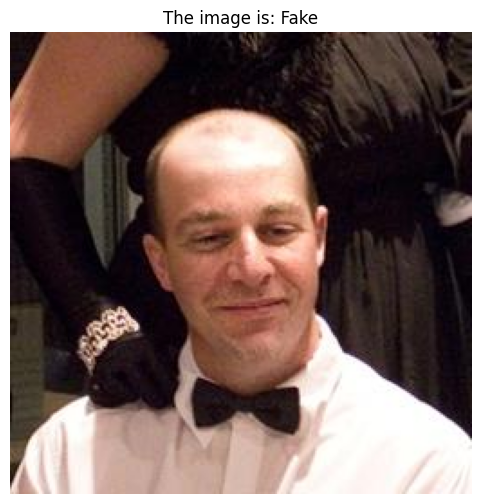

In [43]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import numpy as np
def predict_and_show_image(image_path):
    # Define image transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Load MesoNet model and make prediction
    model = MesoNet().to(device)
    model.load_state_dict(torch.load('mesonet_model2.pth'))
    model.eval()

    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = output.max(1)
    
    # Map the prediction to class names
    class_names = ['Fake', 'Real']
    predicted_class = class_names[predicted.item()]

    # Display the image and prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(np.array(image))
    plt.title(f'The image is: {predicted_class}')
    plt.axis('off')
    plt.show()

# Example usage
image_path = 'val_sample_150/fake/fake_9994.jpg'
predict_and_show_image(image_path)